In [38]:
import re
import time
import warnings
import unicodedata

import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
warnings.filterwarnings('ignore')

### Preparing data

In [40]:
train_df=pd.read_csv("data/train.csv", encoding="utf-8")
test_df=pd.read_csv("data/test.csv", encoding="utf-8")
valid_df=pd.read_csv("data/valid.csv", encoding="utf-8")

In [41]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    """
    Normalizes latin chars with accent to their canonical decomposition
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",","'","äöüß")
    w = re.sub(r"[^a-zA-Z?.!,¿'äöüß]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '[START] ' + w + ' [END]'
    return w

In [42]:
train_df["eng"] = train_df.eng.apply(lambda w: preprocess_sentence(w))
train_df["deu"] = train_df.deu.apply(lambda w: preprocess_sentence(w))


test_df["eng"] = test_df.eng.apply(lambda w: preprocess_sentence(w))
test_df["deu"] = test_df.deu.apply(lambda w: preprocess_sentence(w))


valid_df["eng"] = valid_df.eng.apply(lambda w: preprocess_sentence(w))
valid_df["deu"] = valid_df.deu.apply(lambda w: preprocess_sentence(w))

In [43]:
train_df.head()

,eng,deu
0,[START] i've already drunk three cups of coffe...,[START] ich habe schon drei tassen kaffee getr...
1,[START] tom finally succeeded in getting mary ...,"[START] es ist tom endlich gelungen , maria ei..."
2,[START] i imagine that's true . [END],"[START] ich denke , das ist wahr . [END]"
3,[START] i need something smaller . [END],[START] ich brauche etwas kleineres . [END]
4,[START] a green banana is not ripe enough to e...,[START] eine grune banane ist nicht reif genug...


In [44]:
# This class creates a word -> index mapping for each language
class LanguageTokenizer():
    def __init__(self, lang):
        """ lang are the list of phrases from each language"""
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            # update with individual tokens
            self.vocab.update(phrase.split(' '))

        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0

        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token

        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

    def tokenize(self, sentence):
        """ returns a list of indexes (for each token in the sentence) """
        return [self.word2idx[word] for word in sentence.split(' ')]

    def detokenize(self, encoded_tokens):
        """
        Takes a list of indexes (representing a sentence) and returns the sentence
        """
        words = [self.idx2word[int(token)] for token in encoded_tokens if int(token) != 0]

        # remove [START] and [END] tokens
        words=words[1:-1]
        return ' '.join(words)

    def lookup(self,encoded_tokens):
        """
        Takes a list of indexes (representing a sentence) and returns the sentence
        """
        words = [self.idx2word[int(token)] for token in encoded_tokens]

        return ' '.join(words)

In [45]:
# index language using the class above
inp_lang_train = LanguageTokenizer(train_df["deu"].values.tolist())
targ_lang_train = LanguageTokenizer(train_df["eng"].values.tolist())

inp_lang_valid=LanguageTokenizer(valid_df["deu"].values.tolist())
targ_lang_valid=LanguageTokenizer(valid_df["eng"].values.tolist())

inp_lang_test=LanguageTokenizer(test_df["deu"].values.tolist())
targ_lang_test=LanguageTokenizer(test_df["eng"].values.tolist())

In [46]:
# Vectorize the input and target languages
input_tensor_train=[inp_lang_train.tokenize(sentence) for sentence in train_df["deu"].values.tolist()]
target_tensor_train=[targ_lang_train.tokenize(sentence) for sentence in train_df["eng"].values.tolist()]

input_tensor_valid=[inp_lang_valid.tokenize(sentence) for sentence in valid_df["deu"].values.tolist()]
target_tensor_valid=[targ_lang_valid.tokenize(sentence) for sentence in valid_df["eng"].values.tolist()]

input_tensor_test=[inp_lang_test.tokenize(sentence) for sentence in test_df["deu"].values.tolist()]
target_tensor_test=[targ_lang_test.tokenize(sentence) for sentence in test_df["eng"].values.tolist()]


for row in input_tensor_train[:10]:
    print(row)

[8, 13875, 12204, 22803, 6202, 25396, 14554, 11443, 5, 7]
[8, 8363, 14266, 25865, 7345, 10745, 4, 17528, 6735, 11332, 13916, 29594, 10378, 31240, 7525, 5, 7]
[8, 13875, 5799, 4, 5636, 14266, 29592, 5, 7]
[8, 13875, 4944, 8419, 15240, 5, 7]
[8, 6769, 12071, 2900, 14266, 19096, 21203, 10876, 31416, 8380, 5, 7]
[8, 25865, 30661, 19128, 8419, 29169, 5770, 26230, 4, 30706, 30482, 13910, 3004, 5, 7]
[8, 30482, 12482, 6769, 25856, 30961, 5, 7]
[8, 8363, 18791, 28994, 30138, 30961, 13978, 1348, 4, 17755, 5879, 22099, 31445, 25016, 31240, 8352, 4, 762, 5636, 3464, 17754, 908, 13783, 5821, 8649, 29679, 5, 7]
[8, 4599, 6769, 18684, 13379, 1, 7]
[8, 25865, 12478, 6735, 19670, 12152, 9501, 11349, 5, 7]


In [47]:
detokenize_tensor=[targ_lang_train.detokenize(s) for s in target_tensor_train[:10]]
detokenize_tensor

["i've already drunk three cups of coffee .",
 'tom finally succeeded in getting mary to tell him how she really felt .',
 "i imagine that's true .",
 'i need something smaller .',
 'a green banana is not ripe enough to eat .',
 'tom never wanted to do anything we asked him to do .',
 'we had a great time .',
 'it took far less time to house train my alsatian than my other dog .',
 'please leave a message .',
 'tom asked a few good questions .']

In [48]:
for s in input_tensor_train[:10]:
    print(inp_lang_train.lookup(s))

[START] ich habe schon drei tassen kaffee getrunken . [END]
[START] es ist tom endlich gelungen , maria ein gestandnis ihrer wahren gefuhle zu entlocken . [END]
[START] ich denke , das ist wahr . [END]
[START] ich brauche etwas kleineres . [END]
[START] eine grune banane ist nicht reif genug zum essen . [END]
[START] tom wollte nie etwas von dem tun , worum wir ihn baten . [END]
[START] wir hatten eine tolle zeit . [END]
[START] es nahm viel weniger zeit in anspruch , meinen deutschen schaferhund zur stubenreinheit zu erziehen , als das bei meinem anderen hund der fall war . [END]
[START] bitte eine nachricht hinterlassen ! [END]
[START] tom hat ein paar gute fragen gestellt . [END]


In [49]:
input_tensor_train=[torch.tensor(sentence) for sentence in input_tensor_train]
target_tensor_train=[torch.tensor(sentence) for sentence in target_tensor_train]

input_tensor_valid=[torch.tensor(sentence) for sentence in input_tensor_valid]
target_tensor_valid=[torch.tensor(sentence) for sentence in target_tensor_valid]

input_tensor_test=[torch.tensor(sentence) for sentence in input_tensor_test]
target_tensor_test=[torch.tensor(sentence) for sentence in target_tensor_test]

In [50]:
class Config:
    BATCH_SIZE=64

    embedding_dim=256
    units=1024
    vocab_inp_size=len(inp_lang_train.word2idx)
    vocab_tar_size=len(targ_lang_train.word2idx)
    num_layers=4
    d_model=128
    dff=512
    num_heads=8
    dropout_rate=0.1

    workers=2
    epochs=200
    patience=5
    learning_rate=0.00003

    load_weights_path = "/"
    save_file_name = "model_weights_transformer"

    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
#inplace padding
input_tensor_train=nn.utils.rnn.pad_sequence(input_tensor_train, batch_first=True, padding_value=0)
target_tensor_train=nn.utils.rnn.pad_sequence(target_tensor_train, batch_first=True, padding_value=0)

input_tensor_valid=nn.utils.rnn.pad_sequence(input_tensor_valid, batch_first=True, padding_value=0)
target_tensor_valid=nn.utils.rnn.pad_sequence(target_tensor_valid, batch_first=True, padding_value=0)

input_tensor_test=nn.utils.rnn.pad_sequence(input_tensor_test, batch_first=True, padding_value=0)
target_tensor_test=nn.utils.rnn.pad_sequence(target_tensor_test, batch_first=True, padding_value=0)

In [52]:
class LanguageDataset(Dataset):
    def __init__(self, deu, eng,max_tokens=128):
        self.deu=deu
        self.eng=eng
        self.max_tokens=max_tokens

    def __getitem__(self,index):
        eng=self.eng[index]
        deu=self.deu[index]

        deu=deu[:self.max_tokens]
        eng=eng[:(self.max_tokens+1)]

        eng_inputs=eng[:-1]
        eng_labels=eng[1:]

        return (deu,eng_inputs),eng_labels

    def __len__(self):
        return len(self.deu)

In [53]:
train_dataset=LanguageDataset(input_tensor_train,target_tensor_train)
train_loader=DataLoader(train_dataset,
                        shuffle=True,
                        drop_last=True,
                        batch_size=Config.BATCH_SIZE)

valid_dataset=LanguageDataset(input_tensor_valid,target_tensor_valid)
valid_loader=DataLoader(valid_dataset,
                        batch_size=Config.BATCH_SIZE,
                        drop_last=True)

test_dataset=LanguageDataset(input_tensor_test,target_tensor_test)
test_loader=DataLoader(test_dataset,
                       batch_size=Config.BATCH_SIZE,
                       drop_last=True)

In [54]:
for (deu,eng),eng_labels in train_loader:
    print(deu.shape)
    print(eng.shape)
    print(eng_labels.shape)

    print(eng[63][:10])
    print(eng_labels[63][:10])
    break

torch.Size([64, 90])
torch.Size([64, 74])
torch.Size([64, 74])
tensor([   11, 14904, 14824, 13860, 11806,  7228,     8,    10,     0,     0])
tensor([14904, 14824, 13860, 11806,  7228,     8,    10,     0,     0,     0])


In [55]:
def positional_embedding(length,depth):
    depth=depth/2

    positions=torch.arange(length).unsqueeze(1) #shape=(length,1)
    depths=torch.arange(depth).unsqueeze(0)/depth #shape=(1,depth)

    angle_rates=1/(10000**depths) #shape=(1,depth)
    angle_rads=positions*angle_rates #shape=(pos,depth)

    pos_encoding=torch.cat([torch.sin(angle_rads),
                            torch.cos(angle_rads)],
                            dim=-1) #shape=(pos,depth*2)

    return pos_encoding.float()

torch.Size([2048, 512])


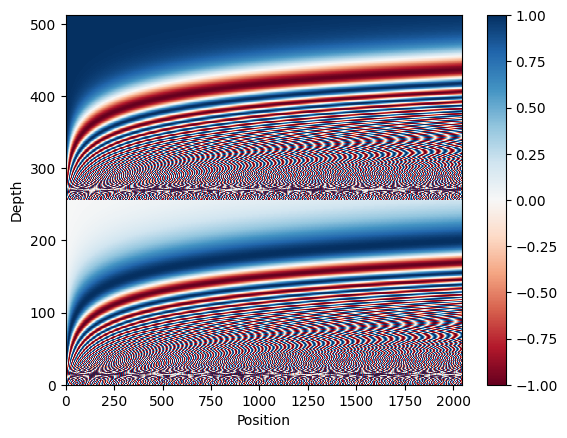

In [56]:
pos_encoding=positional_embedding(length=2048,depth=512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding.numpy().T,cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

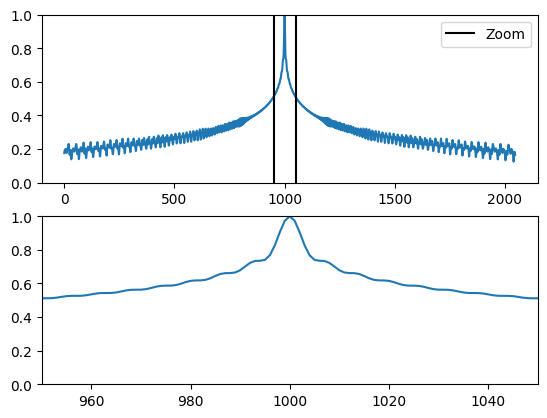

In [57]:
pos_encoding/=torch.norm(pos_encoding,dim=1,keepdim=True)
p=pos_encoding[1000]
dots=torch.einsum('pd,d -> p',pos_encoding,p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [58]:
class PositionalEmbedding(nn.Module):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.d_model=d_model
        self.embedding=nn.Embedding(vocab_size,d_model,padding_idx=0).to(Config.device)
        self.pos_encoding=positional_embedding(length=2048,depth=d_model).to(Config.device)

    def forward(self,x):
        length=x.size(1)
        x=self.embedding(x) #shape=(batch,length,d_model)

        x*=torch.sqrt(torch.tensor(self.d_model,dtype=torch.float32))
        x+=self.pos_encoding[:length,:]
        return x

In [ ]:
embed_deu=PositionalEmbedding(vocab_size=Config.vocab_inp_size,d_model=512)
embed_eng=PositionalEmbedding(vocab_size=Config.vocab_tar_size,d_model=512)

deu_emb=embed_deu(deu.to(Config.device))
en_emb=embed_eng(eng.to(Config.device))

In [ ]:
en_emb.shape

torch.Size([64, 74, 512])

In [ ]:
class BaseAttention(nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.mha=nn.MultiheadAttention(batch_first=True,**kwargs).to(Config.device)
        self.layer_norm=nn.LayerNorm(normalized_shape=kwargs["embed_dim"]).to(Config.device)

In [ ]:
class CrossAttention(BaseAttention):
    def forward(self,x,context):
        x=x.to(Config.device)
        context=context.to(Config.device)
        attn_output,attn_scores=self.mha(
            query=x,
            key=context,
            value=context,
            need_weights=True,
            average_attn_weights=False
        )


        self.last_attn_scores=attn_scores
        x=x+attn_output
        x=self.layer_norm(x)
        return x

In [ ]:
sample_ca=CrossAttention(num_heads=2,embed_dim=512)
print(deu_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb,deu_emb).shape)

torch.Size([64, 90, 512])
torch.Size([64, 74, 512])
torch.Size([64, 74, 512])


In [ ]:
class GlobalSelfAttention(BaseAttention):
    def forward(self,x):
        attn_output,_=self.mha(
            query=x,
            key=x,
            value=x
        )
        x=x+attn_output
        x=self.layer_norm(x)
        return x

In [ ]:
sample_gsa=GlobalSelfAttention(num_heads=2,embed_dim=512)
print(deu_emb.shape)
print(sample_gsa(deu_emb).shape)

torch.Size([64, 90, 512])
torch.Size([64, 90, 512])


In [ ]:
def generate_square_subsequent_mask(seq_len):
  mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask== 1, float(0.0))
  return mask.to(Config.device)

In [ ]:
class CausalSelfAttention(BaseAttention):
    def forward(self,x):
        seq_len=x.size(1)

        causal_mask=generate_square_subsequent_mask(seq_len)
        attn_output,attn_scores=self.mha(
            query=x,
            key=x,
            value=x,
            is_causal=True,
            attn_mask=causal_mask)
        x=x+attn_output
        x=self.layer_norm(x)
        return x


In [ ]:
sample_csa=CausalSelfAttention(num_heads=2,embed_dim=512)
print(en_emb.shape)
print(sample_csa(en_emb).shape)

torch.Size([64, 74, 512])
torch.Size([64, 74, 512])


In [ ]:
class FeedForward(nn.Module):
    def __init__(self,d_model,dff,dropout_rate=0.1):
        super().__init__()
        self.seq=nn.Sequential(
            nn.Linear(d_model,dff),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dff,d_model)
        )
        self.layer_norm=nn.LayerNorm(normalized_shape=d_model)

    def forward(self,x):
        x=x.to(self.seq[0].weight.device)
        x=self.seq(x)
        x=x+self.layer_norm(x)
        return x.to(Config.device)

In [ ]:
sample_ffn=FeedForward(d_model=512,dff=2048)
print(en_emb.shape)
print(sample_ffn(en_emb).shape)

torch.Size([64, 74, 512])
torch.Size([64, 74, 512])


In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self,*,d_model,num_heads,dff,dropout_rate=0.1):
        super().__init__()
        self.self_attention=GlobalSelfAttention(
            num_heads=num_heads,
            embed_dim=d_model,
            dropout=dropout_rate)

        self.ffn=FeedForward(d_model=d_model,dff=dff)

    def forward(self,x):
        x=self.self_attention(x)
        x=self.ffn(x)
        return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(deu_emb.shape)
print(sample_encoder_layer(deu_emb).shape)

torch.Size([64, 90, 512])
torch.Size([64, 90, 512])


In [ ]:
class Encoder(nn.Module):
    def __init__(self,*,num_layers,d_model,num_heads,
                 dff,vocab_size,dropout_rate=0.1):
        super().__init__()

        self.d_model=d_model
        self.num_layers=num_layers

        self.pos_embedding=PositionalEmbedding(
            vocab_size=vocab_size,
            d_model=d_model)

        self.enc_layers=[
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.dropout=nn.Dropout(dropout_rate)

    def forward(self,x):
        x=self.pos_embedding(x)
        x=self.dropout(x)

        for i in range(self.num_layers):
            x=self.enc_layers[i](x)

        return x


In [ ]:
sample_encoder=Encoder(num_layers=4,
                       d_model=512,
                       num_heads=8,
                       dff=2048,
                       vocab_size=Config.vocab_inp_size)

sample_encoder_output=sample_encoder(deu.to(Config.device))

print(deu.shape)
print(sample_encoder_output.shape)

torch.Size([64, 90])
torch.Size([64, 90, 512])


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self,*,d_model,num_heads,
                 dff,dropout_rate=0.1):
        super(DecoderLayer,self).__init__()

        self.causal_self_attention=CausalSelfAttention(
            num_heads=num_heads,
            embed_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention=CrossAttention(
            num_heads=num_heads,
            embed_dim=d_model,
            dropout=dropout_rate)

        self.ffn=FeedForward(d_model=d_model,dff=dff)

    def forward(self,x,context):
        x=self.causal_self_attention(x=x)
        x=self.cross_attention(x=x,context=context)

        self.last_attn_scores=self.cross_attention.last_attn_scores

        x=self.ffn(x)
        return x


In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=deu_emb)

print(en_emb.shape)
print(deu_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

torch.Size([64, 74, 512])
torch.Size([64, 90, 512])
torch.Size([64, 74, 512])


In [ ]:
class Decoder(nn.Module):
    def __init__(self,*,num_layers,d_model,num_heads,
                 dff,vocab_size,dropout_rate=0.1):
        super(Decoder,self).__init__()

        self.d_model=d_model
        self.num_layers=num_layers

        self.pos_embedding=PositionalEmbedding(
            vocab_size=vocab_size,
            d_model=d_model)

        self.dropout=nn.Dropout(dropout_rate)
        self.dec_layers=[
            DecoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores=None

    def forward(self,x,context):
        x=self.pos_embedding(x)
        x=self.dropout(x)

        for i in range(self.num_layers):
            x=self.dec_layers[i](x,context)


        self.last_attn_scores=self.dec_layers[-1].last_attn_scores

        return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=Config.vocab_tar_size)

output = sample_decoder(
    x=eng.to(Config.device),
    context=deu_emb)

# Print the shapes.
print(f"eng shape: {eng.shape}")
print(deu_emb.shape)
print(output.shape)

eng shape: torch.Size([64, 74])
torch.Size([64, 90, 512])
torch.Size([64, 74, 512])


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

torch.Size([64, 8, 74, 90])

In [ ]:
class Transformer(nn.Module):
    def __init__(self,*,num_layers,d_model,num_heads,
                 dff,input_vocab_size,target_vocab_size,
                 dropout_rate=0.1):
        super(Transformer,self).__init__()

        self.encoder=Encoder(num_layers=num_layers,
                             d_model=d_model,
                             num_heads=num_heads,
                             dff=dff,
                             vocab_size=input_vocab_size,
                             dropout_rate=dropout_rate)

        self.decoder=Decoder(num_layers=num_layers,
                             d_model=d_model,
                             num_heads=num_heads,
                             dff=dff,
                             vocab_size=target_vocab_size,
                             dropout_rate=dropout_rate)

        self.final_layer=nn.Linear(d_model,target_vocab_size).to(Config.device)

    def forward(self,inputs):
        context,x=inputs
        context=self.encoder(context)
        x=self.decoder(x,context)
        logits=self.final_layer(x)
        return logits

In [ ]:
transformer=Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=Config.vocab_inp_size,
    target_vocab_size=Config.vocab_tar_size,
    dropout_rate=dropout_rate)

In [ ]:
output=transformer(inputs=(deu.to(Config.device),eng.to(Config.device)))

print(eng.shape)
print(deu.shape)
print(output.shape)
print(eng_labels.shape)

torch.Size([64, 74])
torch.Size([64, 90])
torch.Size([64, 74, 15375])
torch.Size([64, 74])


In [ ]:
print(deu.dtype)

torch.int64


In [ ]:
eng_labels

tensor([[15327,  8026,    12,  ...,     0,     0,     0],
        [ 4064, 11972,  7780,  ...,     0,     0,     0],
        [  674, 15327, 11880,  ...,     0,     0,     0],
        ...,
        [14904,  6227, 13860,  ...,     0,     0,     0],
        [ 5716,  9340, 15336,  ...,     0,     0,     0],
        [ 3794,  7228,  9031,  ...,     0,     0,     0]])

In [ ]:
predicted_ids=torch.argmax(output,dim=-1)
predicted_ids.shape

torch.Size([64, 74])

In [ ]:
print(torch.argmax(output[:, -1:, :],dim=-1).shape)

torch.Size([64, 1])


In [ ]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

torch.Size([64, 8, 74, 90])


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0

    def update(self,val,n=1):
        self.val=val
        self.sum+=val*n
        self.count+=n
        self.avg=self.sum/self.count

In [ ]:
def masked_loss(pred,labels):
    pred=torch.tensor(pred,dtype=torch.float32)
    labels=torch.tensor(labels,dtype=torch.float32)
    mask=labels!=0

    loss=nn.CrossEntropyLoss()
    loss=loss(pred,labels)

    mask=torch.tensor(mask,dtype=loss.dtype)
    loss*=mask

    loss=torch.sum(loss)/torch.sum(mask)
    return loss

def masked_accuracy(pred,labels):
    labels=torch.tensor(labels,dtype=torch.float32)
    match = labels == pred

    mask=labels!=0

    match = match&mask

    match=torch.tensor(match,dtype=torch.float32)
    mask=torch.tensor(mask,dtype=torch.float32)
    return torch.sum(match)/torch.sum(mask)

In [ ]:
train_loss=dict()
valid_loss=dict()
train_acc=dict()
valid_acc=dict()
class Train:
    def __init__(self,model,device,config,save_file_name = 'model_weights', weight_path='./'):
        self.train_loss=dict()
        self.valid_loss=dict()
        self.train_acc=dict()
        self.valid_acc=dict()
        self.model=model
        self.device=device
        self.config=config
        self.best_score=0
        self.best_loss=5000
        self.save_file_name = save_file_name
        self.weight_path = weight_path


    def fit(self,train_loader,valid_loader):

        self.optimizer=torch.optim.Adam(self.model.parameters(),self.config.learning_rate,betas=(0.9,0.98))
        self.scheduler=torch.optim.lr_scheduler.OneCycleLR(self.optimizer,max_lr=self.config.learning_rate,steps_per_epoch=int(len(train_loader)),epochs=self.config.epochs)


        for epoch in range(self.config.epochs):

            t=time.time()
            print("Training started...")

            summary_loss,summary_train_acc=self._train_one_epoch(train_loader)
            self.train_loss[epoch]=summary_loss.avg
            self.train_acc[epoch]=summary_train_acc.avg

            print(f'Train : Epoch {epoch}: | Summary loss: {summary_loss.avg:.3f} | Train Accuracy: {summary_train_acc.avg:} | Training time: {time.time()-t}')

            t=time.time()
            print("Validation started...")

            summary_loss,summary_valid_acc=self.validation(valid_loader)
            self.valid_loss[epoch]=summary_loss.avg
            self.valid_acc[epoch]=summary_valid_acc.avg

            print(f'Valid : Epoch {epoch}: | Summary loss: {summary_loss.avg:.3f} | Valid accuracy: {summary_valid_acc.avg:} | Training time: {time.time()-t}')

            if not self.best_score:
                self.best_score=summary_loss.avg
                print(f"Improved model with best CE loss as {self.best_score}")
                self.model.eval()
                patience=self.config.patience
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},f"{self.weight_path}/{self.save_file_name}.pt")
                continue

            if summary_loss.avg<=self.best_score:
                self.best_score=summary_loss.avg
                patience=self.config.patience
                print(f"Improved model with best validation loss as {self.best_score}")
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},f"{self.weight_path}/{self.save_file_name}.pt")

            else:
                patience-=1
                print("Patience reduced")
                if patience==0:
                    print(f"Early stopping. Lowest validation loss achieved is {self.best_score}")
                    break

    def _train_one_epoch(self,train_loader):
        self.model.train()

        t=time.time()
        summary_loss=AverageMeter()
        summary_acc=AverageMeter()

        for (deu,eng),eng_labels in tqdm(train_loader):
            deu=deu.to(self.device).float32
            eng=eng.to(self.device).float32
            eng_labels=eng_labels.to(self.device).float32

            self.optimizer.zero_grad()
            outputs=self.model(
                inputs=(deu.requires_grad_(),eng.requires_grad_())
            )
            predicted_ids = torch.argmax(outputs, dim=-1)

            loss=masked_loss(predicted_ids, eng_labels)
            trainacc=masked_accuracy(predicted_ids, eng_labels)
            loss.backward()

            self.optimizer.step()
            self.scheduler.step()

            summary_loss.update(loss.detach().item(),self.config.BATCH_SIZE)
            summary_acc.update(trainacc.detach().item(),self.config.BATCH_SIZE)

        return summary_loss,summary_acc

    def validation(self,valid_loader):
        self.model.eval()

        t=time.time()
        summary_loss=AverageMeter()
        summary_acc=AverageMeter()

        for (deu,eng),eng_labels in tqdm(valid_loader):
            deu=deu.to(self.device)
            eng=eng.to(self.device)
            eng_labels=eng_labels.to(self.device)

            with torch.no_grad():
                outputs=self.model(
                    inputs=(deu,eng)
                )
                predicted_ids = torch.argmax(outputs, dim=-1)

                loss=masked_loss(predicted_ids, eng_labels)
                validacc=masked_accuracy(predicted_ids, eng_labels)

                summary_loss.update(loss.detach().item(),self.config.BATCH_SIZE)
                summary_acc.update(validacc.detach().item(),self.config.BATCH_SIZE)

        return summary_loss,summary_acc


In [ ]:
def perform_run(config,model,weight_path='./', load_weights_path=None):
    train_dataset=LanguageDataset(input_tensor_train,target_tensor_train)
    train_loader=DataLoader(train_dataset,shuffle=True,drop_last=True,batch_size=Config.BATCH_SIZE)

    valid_dataset=LanguageDataset(input_tensor_valid,target_tensor_valid)
    valid_loader=DataLoader(valid_dataset,batch_size=Config.BATCH_SIZE,shuffle=True,drop_last=True)

    if load_weights_path is not None:
      model.load_state_dict(torch.load(load_weights_path + f"{config.save_file_name}.pt")["model_state_dict"])
      print("Weight Loaded")

    trainer=Train(model=model.to(Config.device),device=Config.device,config=Config,weight_path=weight_path)
    trainer.fit(train_loader,valid_loader)

In [ ]:
modeltransformer=perform_run(Config,transformer,Config.load_weights_path)

Training started...


  0%|          | 0/2860 [00:00<?, ?it/s]

AttributeError: ignored